In [1]:
from dask import dataframe as dd
import pickle
import tensorflow as tf
from tensorflow import keras
import lightgbm as lgb
import dask
import dask.dataframe as dd
import gzip
import json
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, log_loss
import xgboost as xgb
import seaborn as sns
import matplotlib as plt

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive / float(len(gt))
    return ctr


def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy / strawman_cross_entropy) * 100.0


def quantized_rce(quantiles, pred, gt,doMean=False):
    df = pd.DataFrame(
        {
            'quantiles': quantiles,
            'pred': pred,
            'gt': gt
        }
    )
    if doMean:
        return df.groupby('quantiles').apply(lambda x: compute_rce(x['pred'], x['gt'])).mean()
    return df.groupby('quantiles').apply(lambda x: compute_rce(x['pred'], x['gt']))
    


def quantized_average_precision(quantiles, pred, gt,doMean=False):
    df = pd.DataFrame(
        {
            'quantiles': quantiles,
            'pred': pred,
            'gt': gt
        }
    )
    if doMean:
        return df.groupby('quantiles').apply(lambda x: average_precision_score(x['gt'], x['pred'])).mean()
    return df.groupby('quantiles').apply(lambda x: average_precision_score(x['gt'], x['pred']))

In [2]:
NN_columns=[
    'creator_follower_count',
    'creator_following_count',
    'creator_is_verified',
    'creator_creation_timestamp',
    'engager_follower_count',
    'engager_following_count',
    'engager_is_verified',
    'engager_creation_timestamp',
    'engagement_creator_follows_engager',
    'number_of_photo',
    'number_of_gif',
    'number_of_video',
    'tweet_links_count',
    'tweet_domains_count',
    'tweet_hashtags_count',
    'tweet_hashtags_unique_count',
    'mapped_language_id',
    'mapped_tweet_type',
    'tweet_timestamp_hour_sin',
    'tweet_timestamp_hour_cos',
    'tweet_timestamp_day',
    'tweet_timestamp_weekday',
    'tweet_timestamp_hour_bin',
    'tweet_timestamp_creator_account_age_bin',
    'text_is_reply',
    'text_tokens_count',
    'text_unknown_count',
    'text_special_tokens_count',
    'text_questions_count',
    'text_semantic_separation',
    'text_newline_count',
    'text_separated_count',
    'text_char_count',
    'text_asking_like',
    'text_asking_reply',
    'text_comment_related_count',
    'text_no_comment_related_count',
    'text_asking_retweet',
    'text_nsfw_count',
    'text_kpop_count',
    'text_covid_count',
    'text_sports_count',
    'text_japanesetrending_count',
    'text_anime_count',
    'text_vtuber_count',
    'text_news_count',
    'text_myanmar_count',
    'text_genshin_count',
    'text_crypto_count',
    'text_trending_count',
    'text_love_count',
    'text_slang_count',
    'text_mention_count',
    'engager_follower_quantile',
    'creator_follower_quantile',
    'creator_follower_ratio',
    'engager_follower_ratio',
    'creator_vs_engager_follower_ratio',
    'creator_vs_engager_following_ratio',
    'CE_language__timestamp_hour_bin',
    'CE_language__timestamp_hour_bin__timestamp_weekday',
    'CE_language__type',
    'CE_language__engager_follower_quantile',
    'CE_type__timestamp_weekday',
    'CE_type__timestamp_hour_bin',
    'CE_timestamp_creator_account_age_bin__engager_follower_quantile__creator_follower_quantile',
    'CE_language__presence_of_photo__presence_of_gif__presence_of_video',
    'TE_mapped_engager_id_engagement_reply',
    'TE_number_of_photo_engagement_reply',
    'TE_number_of_gif_engagement_reply',
    'TE_number_of_video_engagement_reply',
    'TE_mapped_tweet_type_engagement_reply',
    'TE_mapped_language_id_engagement_reply',
    'TE_mapped_creator_id_engagement_reply',
    'TE_mapped_tweet_links_id_1_engagement_reply',
    'TE_mapped_tweet_links_id_2_engagement_reply',
    'TE_mapped_tweet_hashtags_id_1_engagement_reply',
    'TE_mapped_tweet_hashtags_id_2_engagement_reply',
    'TE_mapped_domains_id_1_engagement_reply',
    'TE_mapped_domains_id_2_engagement_reply',
    "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_reply",
    'TE_tweet_links_count_engagement_reply',
    'TE_tweet_domains_count_engagement_reply',
    'TE_tweet_hashtags_count_engagement_reply',
    'TE_tweet_hashtags_unique_count_engagement_reply',
    'TE_mapped_engager_id_engagement_retweet',
    'TE_number_of_photo_engagement_retweet',
    'TE_number_of_gif_engagement_retweet',
    'TE_number_of_video_engagement_retweet',
    'TE_mapped_tweet_type_engagement_retweet',
    'TE_mapped_language_id_engagement_retweet',
    'TE_mapped_creator_id_engagement_retweet',
    'TE_mapped_tweet_links_id_1_engagement_retweet',
    'TE_mapped_tweet_links_id_2_engagement_retweet',
    'TE_mapped_tweet_hashtags_id_1_engagement_retweet',
    'TE_mapped_tweet_hashtags_id_2_engagement_retweet',
    'TE_mapped_domains_id_1_engagement_retweet',
    'TE_mapped_domains_id_2_engagement_retweet',
    "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_retweet",
    'TE_tweet_links_count_engagement_retweet',
    'TE_tweet_domains_count_engagement_retweet',
    'TE_tweet_hashtags_count_engagement_retweet',
    'TE_tweet_hashtags_unique_count_engagement_retweet',
    'TE_mapped_engager_id_engagement_comment',
    'TE_number_of_photo_engagement_comment',
    'TE_number_of_gif_engagement_comment',
    'TE_number_of_video_engagement_comment',
    'TE_mapped_tweet_type_engagement_comment',
    'TE_mapped_language_id_engagement_comment',
    'TE_mapped_creator_id_engagement_comment',
    'TE_mapped_tweet_links_id_1_engagement_comment',
    'TE_mapped_tweet_links_id_2_engagement_comment',
    'TE_mapped_tweet_hashtags_id_1_engagement_comment',
    'TE_mapped_tweet_hashtags_id_2_engagement_comment',
    'TE_mapped_domains_id_1_engagement_comment',
    'TE_mapped_domains_id_2_engagement_comment',
    "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_comment",
    'TE_tweet_links_count_engagement_comment',
    'TE_tweet_domains_count_engagement_comment',
    'TE_tweet_hashtags_count_engagement_comment',
    'TE_tweet_hashtags_unique_count_engagement_comment',
    'TE_mapped_engager_id_engagement_like',
    'TE_number_of_photo_engagement_like',
    'TE_number_of_gif_engagement_like',
    'TE_number_of_video_engagement_like',
    'TE_mapped_tweet_type_engagement_like',
    'TE_mapped_language_id_engagement_like',
    'TE_mapped_creator_id_engagement_like',
    'TE_mapped_tweet_links_id_1_engagement_like',
    'TE_mapped_tweet_links_id_2_engagement_like',
    'TE_mapped_tweet_hashtags_id_1_engagement_like',
    'TE_mapped_tweet_hashtags_id_2_engagement_like',
    'TE_mapped_domains_id_1_engagement_like',
    'TE_mapped_domains_id_2_engagement_like',
    "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_like",
    'TE_tweet_links_count_engagement_like',
    'TE_tweet_domains_count_engagement_like',
    'TE_tweet_hashtags_count_engagement_like',
    'TE_tweet_hashtags_unique_count_engagement_like',
    ]

In [3]:
test_set = dd.read_parquet("C:/Users/ALEXDRUSO/Desktop/test").compute()

In [4]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928080 entries, 0 to 53212
Columns: 240 entries, tweet_timestamp to TE_tweet_hashtags_unique_count_engagement_retweet
dtypes: bool(24), datetime64[ns](3), float64(83), int32(23), int64(41), int8(7), object(8), uint16(6), uint8(45)
memory usage: 2.3+ GB


In [5]:
test_set.describe()

,tweet_timestamp,creator_follower_count,creator_following_count,creator_creation_timestamp,engager_follower_count,engager_following_count,engager_creation_timestamp,engagement_reply_timestamp,engagement_retweet_timestamp,engagement_comment_timestamp,...,TE_mapped_tweet_links_id_2_engagement_retweet,TE_mapped_tweet_hashtags_id_1_engagement_retweet,TE_mapped_tweet_hashtags_id_2_engagement_retweet,TE_mapped_domains_id_1_engagement_retweet,TE_mapped_domains_id_2_engagement_retweet,"TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_retweet",TE_tweet_links_count_engagement_retweet,TE_tweet_domains_count_engagement_retweet,TE_tweet_hashtags_count_engagement_retweet,TE_tweet_hashtags_unique_count_engagement_retweet
count,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,...,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06,1.928080e+06
mean,1.614512e+09,9.543391e+05,4.416633e+03,1.420972e+09,1.024935e+03,8.595203e+02,1.475360e+09,3.383149e+07,1.301490e+08,8.984984e+06,...,8.650145e-02,8.692518e-02,8.674471e-02,8.657980e-02,8.650471e-02,8.758134e-02,8.645821e-02,8.645821e-02,8.661172e-02,8.660236e-02
std,1.747942e+05,5.034315e+06,3.597997e+04,1.300143e+08,1.863390e+04,2.151974e+03,1.151015e+08,2.312511e+08,4.395327e+08,1.201070e+08,...,2.726029e-03,3.854411e-02,2.729434e-02,1.863270e-02,3.046261e-03,6.896020e-02,4.781138e-03,4.781138e-03,8.951402e-03,8.451629e-03
min,1.614211e+09,1.000000e+00,0.000000e+00,1.138309e+09,0.000000e+00,1.000000e+00,1.139414e+09,0.000000e+00,0.000000e+00,0.000000e+00,...,2.297695e-03,4.260491e-04,6.671000e-04,1.871773e-04,1.599739e-03,1.920394e-04,7.391339e-02,7.391339e-02,5.942814e-02,5.763892e-02
25%,1.614359e+09,1.582000e+03,2.180000e+02,1.298559e+09,5.700000e+01,1.720000e+02,1.384192e+09,0.000000e+00,0.000000e+00,0.000000e+00,...,8.650589e-02,8.227579e-02,8.400207e-02,8.821356e-02,8.650589e-02,5.481142e-02,8.821356e-02,8.821356e-02,8.227579e-02,8.234158e-02
50%,1.614512e+09,1.432600e+04,6.460000e+02,1.430358e+09,2.040000e+02,3.910000e+02,1.511829e+09,0.000000e+00,0.000000e+00,0.000000e+00,...,8.650589e-02,8.227579e-02,8.400207e-02,8.821356e-02,8.650589e-02,7.750514e-02,8.821356e-02,8.821356e-02,8.227579e-02,8.234158e-02
75%,1.614666e+09,1.893700e+05,1.788000e+03,1.546430e+09,6.290000e+02,8.880000e+02,1.577821e+09,0.000000e+00,0.000000e+00,0.000000e+00,...,8.650589e-02,8.227579e-02,8.400207e-02,8.821356e-02,8.650589e-02,9.346332e-02,8.821356e-02,8.821356e-02,8.227579e-02,8.234158e-02
max,1.614816e+09,1.294485e+08,4.253259e+06,1.608852e+09,9.027135e+06,8.096630e+05,1.608249e+09,1.614816e+09,1.614816e+09,1.614816e+09,...,5.912543e-01,8.159134e-01,8.928992e-01,9.004905e-01,6.520835e-01,9.078940e-01,2.929193e-01,2.929193e-01,1.289011e-01,1.313404e-01


In [6]:
engagements = ['like', 'reply', 'retweet', 'comment']

engagement_columns = ['engagement_'+engagement+'_timestamp' for engagement in engagements]

targets = test_set[engagement_columns]
targets = targets.mask(targets > 0, 1)
test_set = test_set.drop(engagement_columns, axis=1)

In [7]:
overall_results = {}

# XGBoost

In [8]:
classifiers = {
    engagement : pickle.load(open("C:/Users/ALEXDRUSO/Desktop/models/XGBoost/model_TE_definitive_1.614011e+09_newColsengagement_"+engagement+"_timestamp", "rb"))
    for engagement in engagements
}

In [9]:
results = {}

for engagement in engagements:
    classifier = classifiers[engagement]
    prediction = classifier.predict(xgb.DMatrix(test_set[classifier.feature_names]))
    target = targets['engagement_'+engagement+'_timestamp']
    quantiles = test_set['creator_follower_quantile']
    
    results[engagement] ={
        'AP' : quantized_average_precision(quantiles, prediction, target),
        'RCE' : quantized_rce(quantiles, prediction, target)
    }

In [10]:
for engagement in results:
    print(engagement)
    print('AP: {:.5f}'.format(results[engagement]['AP'].mean()))
    print('RCE: {:.5f}'.format(results[engagement]['RCE'].mean()))
    print('\n')

like
AP: 0.66291
RCE: 18.09090


reply
AP: 0.20703
RCE: 21.74804


retweet
AP: 0.40339
RCE: 23.62908


comment
AP: 0.06902
RCE: 13.84948




In [11]:
for engagement in results:
    print(engagement)
    print('AP')
    print(results[engagement]['AP'].describe())
    print('RCE')
    print(results[engagement]['RCE'].describe())
    print('\n')

like
AP
count    5.000000
mean     0.662905
std      0.018068
min      0.644849
25%      0.658242
50%      0.658998
75%      0.659069
max      0.693369
dtype: float64
RCE
count     5.000000
mean     18.090898
std       1.551992
min      16.079624
25%      17.260908
50%      17.831621
75%      19.525637
max      19.756703
dtype: float64


reply
AP
count    5.000000
mean     0.207034
std      0.007705
min      0.197959
25%      0.202939
50%      0.206656
75%      0.208989
max      0.218627
dtype: float64
RCE
count     5.000000
mean     21.748041
std       1.570763
min      19.600790
25%      21.403336
50%      21.452211
75%      22.378293
max      23.905573
dtype: float64


retweet
AP
count    5.000000
mean     0.403388
std      0.026482
min      0.365552
25%      0.396112
50%      0.399499
75%      0.420647
max      0.435130
dtype: float64
RCE
count     5.000000
mean     23.629079
std       3.565627
min      17.293107
25%      24.537331
50%      25.323263
75%      25.345153
max      25.

In [12]:
overall_results["XGB"] = results

# LGBM

In [13]:
classifiers = {
    'like' : lgb.Booster(model_file="C:/Users/ALEXDRUSO/Desktop/models/LGBM_fancy/LightGBM_training_final_dataset/LightGBM_like/lightgbm_like_1624480146.7227838.txt"), 
    'reply' : lgb.Booster(model_file="C:/Users/ALEXDRUSO/Desktop/models/LGBM_fancy/LightGBM_training_final_dataset/LightGBM_reply/lightgbm_reply_1624481210.4095285.txt"),
    'retweet' : lgb.Booster(model_file="C:/Users/ALEXDRUSO/Desktop/models/LGBM_fancy/LightGBM_training_final_dataset/LightGBM_retweet/lightgbm_retweet_1624481196.9369323.txt"), 
    'comment' : lgb.Booster(model_file="C:/Users/ALEXDRUSO/Desktop/models/LGBM_fancy/LightGBM_training_final_dataset/LightGBM_comment\lightgbm_comment_1624481846.83218.txt")
}

In [14]:
test_set.columns = [column.replace(" ", "_") for column in test_set.columns]

In [15]:
results = {}

for engagement in engagements:
    classifier = classifiers[engagement]
    used_columns = [c.replace("apice", "'").replace('virgola',',') for c in classifier.feature_name()]
    prediction = classifier.predict(test_set[used_columns])
    target = targets['engagement_'+engagement+'_timestamp']
    quantiles = test_set['creator_follower_quantile']
    
    results[engagement] ={
        'AP' : quantized_average_precision(quantiles, prediction, target),
        'RCE' : quantized_rce(quantiles, prediction, target)
    }

In [16]:
for engagement in results:
    print(engagement)
    print('AP: {:.5f}'.format(results[engagement]['AP'].mean()))
    print('RCE: {:.5f}'.format(results[engagement]['RCE'].mean()))
    print('\n')

like
AP: 0.66849
RCE: 18.49623


reply
AP: 0.20637
RCE: 21.71897


retweet
AP: 0.40563
RCE: 23.81607


comment
AP: 0.07069
RCE: 14.16734




In [17]:
for engagement in results:
    print(engagement)
    print('AP')
    print(results[engagement]['AP'].describe())
    print('RCE')
    print(results[engagement]['RCE'].describe())
    print('\n')

like
AP
count    5.000000
mean     0.668485
std      0.018660
min      0.650315
25%      0.661343
50%      0.664424
75%      0.666384
max      0.699961
dtype: float64
RCE
count     5.000000
mean     18.496227
std       1.465770
min      16.599143
25%      17.752996
50%      18.215072
75%      19.737797
max      20.176126
dtype: float64


reply
AP
count    5.000000
mean     0.206373
std      0.009343
min      0.195933
25%      0.203207
50%      0.203346
75%      0.208261
max      0.221118
dtype: float64
RCE
count     5.000000
mean     21.718966
std       1.583394
min      19.572800
25%      21.346210
50%      21.369992
75%      22.428560
max      23.877268
dtype: float64


retweet
AP
count    5.000000
mean     0.405627
std      0.028813
min      0.362078
25%      0.398640
50%      0.405332
75%      0.424586
max      0.437499
dtype: float64
RCE
count     5.000000
mean     23.816070
std       3.640469
min      17.335834
25%      24.856958
50%      25.489942
75%      25.550645
max      25.

In [18]:
overall_results["LGBM"] = results

# NN

In [19]:
test_set = dd.read_parquet("C:/Users/ALEXDRUSO/Desktop/test", columns=NN_columns).astype(np.float32).compute()

In [20]:
classifiers = {
    engagement : keras.models.load_model("C:/Users/ALEXDRUSO/Desktop/models/NN/"+engagement+"_")
    for engagement in engagements
}

In [21]:
results = {}

for engagement in engagements:
    classifier = classifiers[engagement]
    prediction = classifier.predict(test_set.to_numpy(copy=False),batch_size=4096).ravel()
    target = targets['engagement_'+engagement+'_timestamp']
    quantiles = test_set['creator_follower_quantile']
    
    results[engagement] ={
        'AP' : quantized_average_precision(quantiles, prediction, target),
        'RCE' : quantized_rce(quantiles, prediction, target)
    }

In [22]:
for engagement in results:
    print(engagement)
    print('AP: {:.5f}'.format(results[engagement]['AP'].mean()))
    print('RCE: {:.5f}'.format(results[engagement]['RCE'].mean()))
    print('\n')

like
AP: 0.66144
RCE: 17.24350


reply
AP: 0.20014
RCE: 21.29406


retweet
AP: 0.38517
RCE: 22.43584


comment
AP: 0.05978
RCE: 12.71720




In [23]:
for engagement in results:
    print(engagement)
    print('AP')
    print(results[engagement]['AP'].describe())
    print('RCE')
    print(results[engagement]['RCE'].describe())
    print('\n')

like
AP
count    5.000000
mean     0.661439
std      0.018670
min      0.637322
25%      0.654036
50%      0.659421
75%      0.668425
max      0.687989
dtype: float64
RCE
count     5.000000
mean     17.243500
std       1.782000
min      14.944379
25%      16.276174
50%      16.999064
75%      18.640116
max      19.357769
dtype: float64


reply
AP
count    5.000000
mean     0.200141
std      0.007913
min      0.190641
25%      0.196156
50%      0.200679
75%      0.201129
max      0.212102
dtype: float64
RCE
count     5.000000
mean     21.294059
std       1.380523
min      19.350466
25%      20.627065
50%      21.711000
75%      21.750156
max      23.031607
dtype: float64


retweet
AP
count    5.000000
mean     0.385167
std      0.032855
min      0.331758
25%      0.383009
50%      0.387408
75%      0.407704
max      0.415954
dtype: float64
RCE
count     5.000000
mean     22.435837
std       3.777141
min      15.725864
25%      23.432936
50%      24.121411
75%      24.227576
max      24.

In [24]:
overall_results["NN"] = results

# Fairness

In [25]:
overall_results['XGB']

{'like': {'AP': quantiles
  0    0.659069
  1    0.658998
  2    0.658242
  3    0.644849
  4    0.693369
  dtype: float64,
  'RCE': quantiles
  0    19.756703
  1    17.831621
  2    17.260908
  3    16.079624
  4    19.525637
  dtype: float64},
 'reply': {'AP': quantiles
  0    0.206656
  1    0.202939
  2    0.197959
  3    0.218627
  4    0.208989
  dtype: float64,
  'RCE': quantiles
  0    21.452211
  1    19.600790
  2    21.403336
  3    22.378293
  4    23.905573
  dtype: float64},
 'retweet': {'AP': quantiles
  0    0.365552
  1    0.435130
  2    0.420647
  3    0.399499
  4    0.396112
  dtype: float64,
  'RCE': quantiles
  0    17.293107
  1    25.345153
  2    25.323263
  3    24.537331
  4    25.646542
  dtype: float64},
 'comment': {'AP': quantiles
  0    0.132098
  1    0.054232
  2    0.049244
  3    0.052593
  4    0.056946
  dtype: float64,
  'RCE': quantiles
  0    14.388229
  1    13.415114
  2    11.982900
  3    13.572351
  4    15.888798
  dtype: float64}}

In [26]:
data = {
    'model':[],
    'engagement':[],
    'AP':[],
    'RCE':[],
    'quantile':[]
}

In [27]:
for model in overall_results:
    for engagement in overall_results[model]:
        length = len(overall_results[model][engagement]['AP'])
        quantiles = overall_results[model][engagement]['AP'].reset_index()
        data['model'] += [model]*length
        data['engagement'] += [engagement]*length
        data['quantile'] += list(quantiles['quantiles'])
        
        for metric in ['AP', 'RCE']:
            result = overall_results[model][engagement][metric]
            data[metric] += list(result)

In [28]:
data = pd.DataFrame(data)

In [29]:
data['quantile'] = data['quantile'].astype(int)

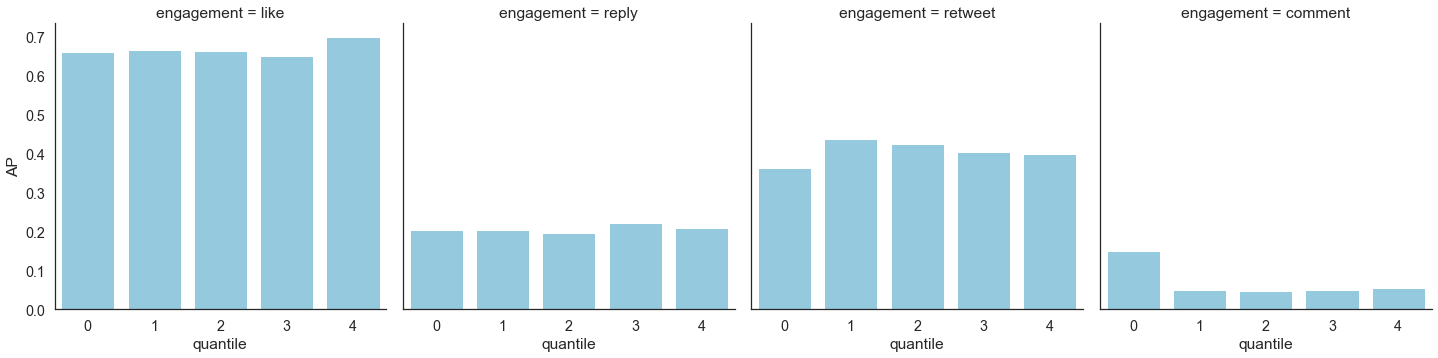

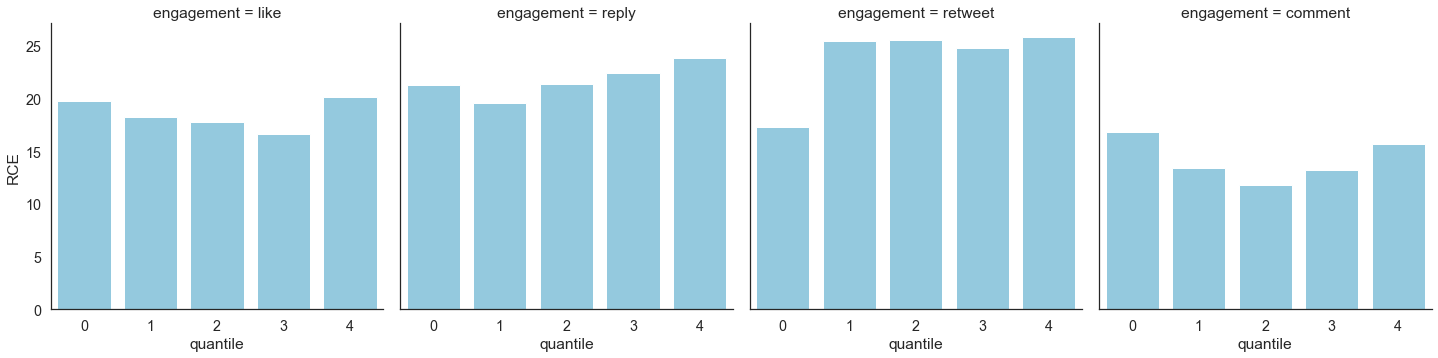

In [30]:
sns.set_context('paper') 
sns.set(font_scale = 1.3)
sns.set_style('white')

for metric in ['AP', 'RCE']:
    image = sns.catplot(
        data=data[data['model']=='LGBM'], 
        x='quantile', 
        y=metric, 
        col='engagement',
        #hue='model', 
        kind='bar',
        #palette='Set2',
        color='skyblue'
    )
    
    image.savefig("LGBM_"+metric+"_quantized.png", dpi=500, transparent=True)

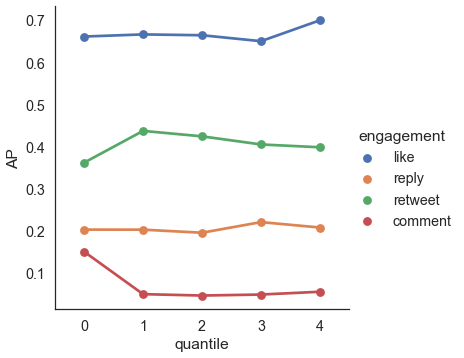

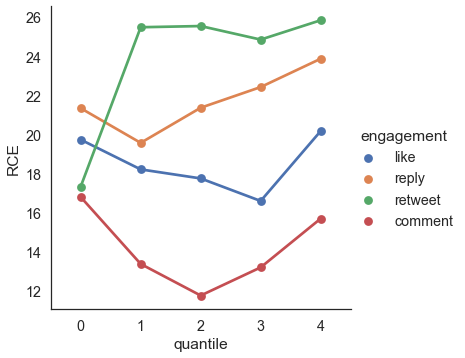

In [31]:
sns.set_context('paper') 
sns.set(font_scale = 1.3)
sns.set_style('white')

for metric in ['AP', 'RCE']:
    image = sns.catplot(
        data=data[data['model']=='LGBM'], 
        x='quantile', 
        y=metric, 
        hue='engagement',
        kind='point',
        #palette='Set2'
    )
    
    image.savefig("LGBM_"+metric+"_quantized_pointplot.png", dpi=500, transparent=True)

C:\Users\ALEXDRUSO\Anaconda3\envs\RecSysFramework\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


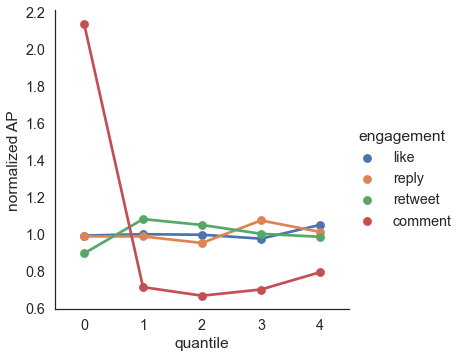

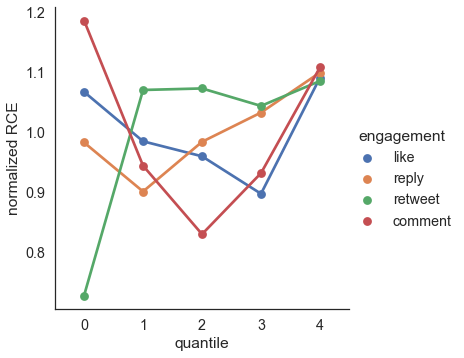

In [32]:
#normalized version

sns.set_context('paper') 
sns.set(font_scale = 1.3)
sns.set_style('white')

temp = data[data['model']=='LGBM']
temp['normalized AP'] = temp.drop('model', axis=1).groupby('engagement')['AP'].transform(lambda x: x/x.mean())
temp['normalized RCE'] = temp.drop('model', axis=1).groupby('engagement')['RCE'].transform(lambda x: x/x.mean())

for metric in ['AP', 'RCE']:
    image = sns.catplot(
        data=temp, 
        x='quantile', 
        y='normalized ' + metric, 
        hue='engagement',
        kind='point',
        #palette='Set2'
    )
    
    image.savefig("LGBM_"+metric+"_quantized_pointplot_normalized.png", dpi=500, transparent=True)

C:\Users\ALEXDRUSO\Anaconda3\envs\RecSysFramework\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


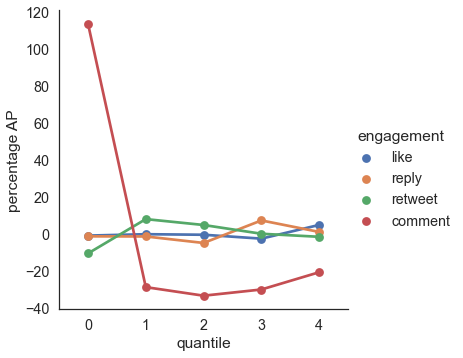

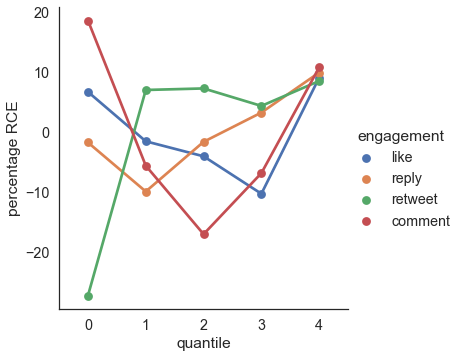

In [33]:
#normalized version

sns.set_context('paper') 
sns.set(font_scale = 1.3)
sns.set_style('white')

temp = data[data['model']=='LGBM']
temp['percentage AP'] = temp.drop('model', axis=1).groupby('engagement')['AP'].transform(lambda x: (x/x.mean()-1)*100)
temp['percentage RCE'] = temp.drop('model', axis=1).groupby('engagement')['RCE'].transform(lambda x: (x/x.mean()-1)*100)

for metric in ['AP', 'RCE']:
    image = sns.catplot(
        data=temp, 
        x='quantile', 
        y='percentage ' + metric, 
        hue='engagement',
        kind='point',
        #palette='Set2'
    )
    
    image.savefig("LGBM_"+metric+"_quantized_pointplot_percentage.png", dpi=500, transparent=True)

In [34]:
 for model in ['XGB', 'LGBM', 'NN']:
    comment_metrics = data[data['engagement'] == 'comment']
    comment_metrics = comment_metrics[comment_metrics['model'] == model]
    avg_ap_comment = comment_metrics['AP'].mean()
    max_ap_comment = comment_metrics['AP'].max()
    print('For model {}:'.format(model))
    print('The maximum AP in the comment class is {:.5f}'.format(max_ap_comment))
    print('The maximum AP in the comment class is {:.2f}% more than the average'.format(((max_ap_comment-avg_ap_comment)/avg_ap_comment)*100))

For model XGB:
The maximum AP in the comment class is 0.13210
The maximum AP in the comment class is 91.38% more than the average
For model LGBM:
The maximum AP in the comment class is 0.15110
The maximum AP in the comment class is 113.75% more than the average
For model NN:
The maximum AP in the comment class is 0.11250
The maximum AP in the comment class is 88.20% more than the average


In [35]:
len(test_set)

1928080

In [36]:
positive_comments = test_set[targets['engagement_comment_timestamp'] == 1]

len(positive_comments)

10730

In [37]:
positive_comments_first_quantile = positive_comments[positive_comments['creator_follower_quantile']==0]

len(positive_comments_first_quantile)

30

In [38]:
first_quantile = test_set[test_set['creator_follower_quantile'] == 0]

len(first_quantile)

2940

In [39]:
print('First quantile examples account for {:.2f}% of the test set'.format(len(first_quantile)/len(test_set) * 100))
print('Only {:.2f}% of the first quantile examples are positive interactions'.format(len(positive_comments_first_quantile)/len(first_quantile)*100))

First quantile examples account for 0.15% of the test set
Only 1.02% of the first quantile examples are positive interactions
